In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\RAVI GUPTA\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#--Importing keras model and necessary classes
from keras.models import Model
from keras.models import Sequential
from keras.layers import Activation,Conv2D,Dense,MaxPool2D,Input,Flatten,BatchNormalization,Dropout
from keras.models import model_from_yaml

Using TensorFlow backend.


# Pre_Processing the Devanagari files images

In [1]:
akshar_image_folders = os.listdir("train")

In [3]:
list_of_images = []

list_of_labels = []

label_index = 0

for akshar_folder in akshar_image_folders:
    
    each_folder_path = os.path.join("train",
                                   akshar_folder)
    
    images = os.listdir(each_folder_path)
    
    img_shape = plt.imread(os.path.join(each_folder_path,images[0])).shape
    
    blank_array = np.zeros((len(images),(img_shape[0]*img_shape[1]))) 
    
    blank_label_array = label_index*(np.ones((len(images),1)))
    
    index = 0
    
    for image in images:
        
        img_in_array = plt.imread(os.path.join(each_folder_path,image))
        
        blank_array[index] = img_in_array.reshape(1,(img_in_array.shape[0]*img_in_array.shape[1]))
        
        index += 1
        
    list_of_images.append(blank_array)
    
    list_of_labels.append(blank_label_array)
    
    label_index += 1

In [4]:
tuple_of_label_arrays = tuple(list_of_labels)

tuple_of_arrays = tuple(list_of_images)

stacked_up_images = np.concatenate(tuple_of_arrays)

print(stacked_up_images.shape)

stacked_up_labels = np.concatenate(tuple_of_label_arrays)

print(stacked_up_labels.shape)

stacked_up_labels = np.int32(stacked_up_labels)

rawdata = pd.DataFrame(stacked_up_images)

(78200, 1024)
(78200, 1)


# One_Hot_Encoding of the labels

In [5]:
#---one hot encoding of labels
one_hot_labels = np.eye(len(akshar_image_folders),
                        len(akshar_image_folders))[stacked_up_labels[:,0]]

# Preparing Model Layers

* In this we use 2 Convulational Layers, 2 Hidden Layers and Output layer

In [8]:
#--input layer for entering of given data
inp_layer = Input(shape=(32,32,1))

model = Sequential()

#--Creating two convulational layer and before entering of data into next layer we applying batch normalization technique 
#  which improve accuracy drastically

model.add(Conv2D(filters=10,kernel_size=[5,5],activation=tf.nn.relu))
model.add(BatchNormalization())

model.add(Conv2D(filters=10,kernel_size=[5,5],activation=tf.nn.relu))
model.add(BatchNormalization())

#--maxpooling the output of convulational layer and before the feeding into Fully Connected Layer
#--and this technique help to reduce the no. units of neurons in any layer by downsampling

model.add(MaxPool2D(strides=(2,2)))

#--streching a image to single row

model.add(Flatten())          
          
#--Creating Two Fully Connected Hidden layer and also use Batch Normalization Techinque

model.add(Dense(units=16*16*10,activation=tf.nn.relu,kernel_initializer='he_normal'))
model.add(BatchNormalization())
          
model.add(Dense(units=16*16*10,activation=tf.nn.relu,kernel_initializer='he_normal'))
model.add(BatchNormalization())
          
          
#--Ouput layer which contain 46 neurons for 46 classes

model.add(Dense(units=46,activation=tf.nn.softmax))

# Model Training

In [9]:
from keras.optimizers import Adam
adam = Adam(lr=0.01,beta_1=0.9,beta_2=0.999,decay=0.1)

model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

# stacked_up_images = stacked_up_images/255   --not effective technique in NN ..i think it generally reduce the variability of values which decrease the accuracy

reshaped_data = np.reshape(stacked_up_images,(-1,32,32,1))

history = model.fit(x=reshaped_data,y=one_hot_labels,batch_size=500,epochs=2,)

Epoch 1/2
78200/78200 [==============================] - 70s 897us/step - loss: 0.5859 - acc: 0.8862
Epoch 2/2
78200/78200 [==============================] - 53s 678us/step - loss: 0.0667 - acc: 0.9823


# Saving The Trained Model

In [10]:
model.save_weights('CNN_Devanagari_model.h5')  #--Saving the trained weights of model

model_yaml = model.to_yaml()  #--Serialize the Yaml

with open('trained_model.yaml','w') as yaml_file:  #--saving the architecture of model
    yaml_file.write(model_yaml)

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        260       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 10)        40        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 10)        2510      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 10)        40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1440)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2560)              3688960   
__________

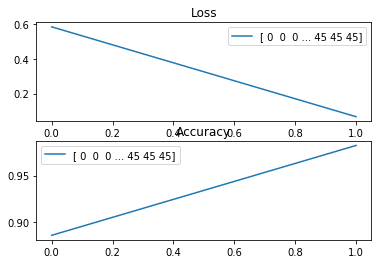

In [13]:
from matplotlib import pyplot

pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label=stacked_up_labels[:,0])
# pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['acc'], label=stacked_up_labels[:,0])
# pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()